# 1. 면역원성(Immunogenicity) 예측

고분자 물질(예를 들면 단백질 의약품)이 체내에 들어왔을때 면역반응을 유발하는 성질을 면역원성 (immunogenicity)이라 합니다. 면역원성은 단백질 의약품의 약효뿐만 아니라 환자의 에도 문제를 일으킬수 있습니다. 따라서 재조합 단백질이나 항체와 같은 단백질 의약품 개발 시 면역원성을 사전에 예방하고 최소화하는 것이 반드시 필요하죠. 

 *in silico* 기술을 활용하여 기존의 알려진 DB를 검색하여 면역원성을 예측하는 방법을 알아 보겠습니다. 

## 1.1. NetMHC 4.0 Server

MHC class I에 붙는 펩타이드를 예측해주는 프로그램입니다. 다음은 홈페이지의 소개 글입니다.

>Prediction of peptide-MHC class I binding using artificial neural networks (ANNs). ANNs have been trained for 81 different Human MHC alleles including HLA-A, -B, -C and -E. Furthermore, predictions for 41 animal (Monkey, Cattle, Pig, and Mouse) alleles are available.

단백질 서열만 넣어주면 어느 부분이 MHC class I에 붙을지를 계산해 줍니다. 궁극적으로 이것을 통해 Immunogenicity를 예측 할 수 있습니다.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

필요한 라이브러리를 불러오고, NetMHC 서버에서 나온 결과를 엑셀파일로 다운받아 로컬에 저장합니다.

In [3]:
# parse the excel file
xls = pd.ExcelFile('G:\prediction.xlsx') # 위치와 파일명은 변경해주세요.

# make dataframe from sheet
df_M113HC = xls.parse('M113 (HC)',index_col=0)
df_M113LC = xls.parse('M113 (LC)',index_col=0)
df_mAb2021HC = xls.parse('mAb2021 (HC)',index_col=0)
df_mAb2021LC = xls.parse('mAb2021 (LC)',index_col=0)
df_Bay_HC = xls.parse('Bay-B (HC)',index_col=0)
df_Bay_LC = xls.parse('Bay-B (LC)',index_col=0)

엑셀파일을 **pandas** 라이브러리를 통해 읽어들이고, 각각의 시트를 각각의 데이터프레임으로 만들었습니다. 잘 만들어 졌는지 하나의 데이터프레임을 표시해 보겠습니다.

In [4]:
df_M113HC.head() 

,DRB1_0101,DRB1_0301,DRB1_0401,DRB1_0403,DRB1_0405,DRB1_0406,DRB1_0410,DRB1_0701,DRB1_0802,DRB1_0803,DRB1_0901,DRB1_1101,DRB1_1201,DRB1_1202,DRB1_1301,DRB1_1302,DRB1_1401,DRB1_1407,DRB1_1501,DRB1_1502
Peptide,,,,,,,,,,,,,,,,,,,,
EVQLVESGGGLVKPG,311.99,8664.84,3989.47,6338.94,5373.34,6338.94,2634.71,1082.11,5368.11,1715.37,714.05,5425.98,1391.91,2083.95,685.17,758.31,4138.06,6196.80,1946.21,3408.39
VQLVESGGGLVKPGG,350.21,9685.61,5547.56,8448.85,7251.92,8448.85,3781.46,1250.97,6269.37,2049.98,829.42,6173.44,1778.93,2698.32,831.89,893.20,4808.39,6974.27,2254.98,3797.98
QLVESGGGLVKPGGS,744.61,12900.80,8900.20,12395.21,10933.17,12395.21,6455.01,2376.86,8643.02,3217.39,1483.77,8500.01,2978.00,4274.31,1517.35,1651.02,7602.71,9759.88,3819.41,5610.82
LVESGGGLVKPGGSL,2031.56,19704.16,13747.03,17624.09,16544.21,17624.09,12547.56,5857.65,9547.54,4827.00,3480.35,10593.37,5764.85,7177.91,4684.63,5097.43,13908.77,14562.81,7342.24,8169.02
VESGGGLVKPGGSLR,1573.87,8900.58,12312.74,17260.07,16667.82,17260.07,11976.50,5182.46,8052.22,2695.43,3503.55,5319.49,2526.99,3082.52,5448.22,6827.86,8645.83,12890.06,5489.64,7360.93


**df_M113HC** 데이터프레임을 보면 인덱스로는 펩타이드 서열이 있고, 각각의 열은 **alleles** 를 나타냅니다. allele에 대해서는 [위키피디아](https://en.wikipedia.org/wiki/Allele)를 참고하세요. 숫자는 펩타이드가 붙을 확률을 나타냅니다. 숫자가 크면 가능성이 크고, 낮으면 적다고 볼 수 있습니다.

우리가 알고 싶은 것은 각각의 아미노산으로 유발되는 면역원성임으로 Peptide의 첫번째 아미노산만 남겨줍니다.

In [5]:
def make_simple(df):
    ''' 
    peptide의 맨 앞 아미노산만 남기기
    '''
    df2 = df.rename(index = lambda x : x[:1])
    return df2

## 1.2. 시각화하기 

다음과 같이 [히트맵](https://ko.wikipedia.org/wiki/%ED%9E%88%ED%8A%B8_%EB%A7%B5)을 그리는 기능을 만들어 사용하겠습니다.

In [5]:
def drawing_plot(x):
    '''
    그림 그리기
    '''
    # 그림 사이즈 정하기
    plt.figure(figsize=(100,5))
    # 컬러맵과 최대값과 최소값을 정하기
    sns.heatmap(make_seq(x).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
    # 그림 저장 옵션
    plt.savefig(str(x)+'.png',dpi=120, format='png')

실제로는 아래와 같이 하드코딩을 통해서 진행을 해버렸습니다.

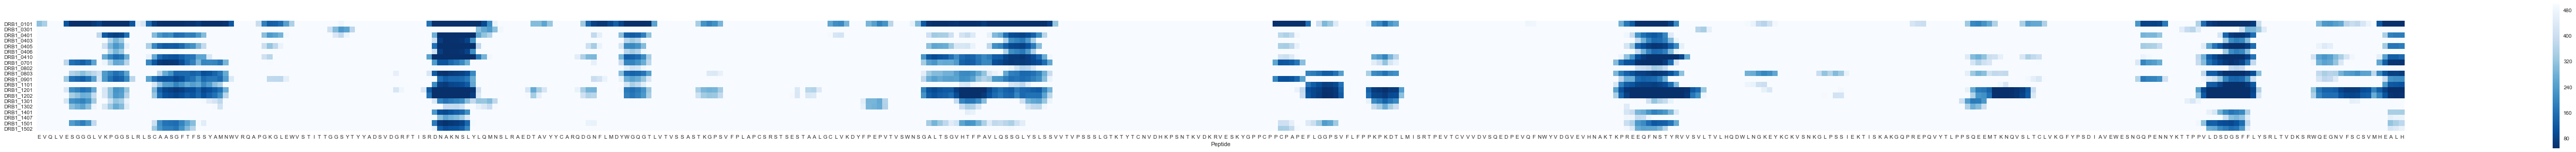

In [18]:
# 플롯 그리기
plt.figure(figsize=(100,5))
sns.heatmap(make_simple(df_MG1113HC).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
plt.savefig('df_M113HC.png',dpi=120,format='png',bbox_inches='tight')


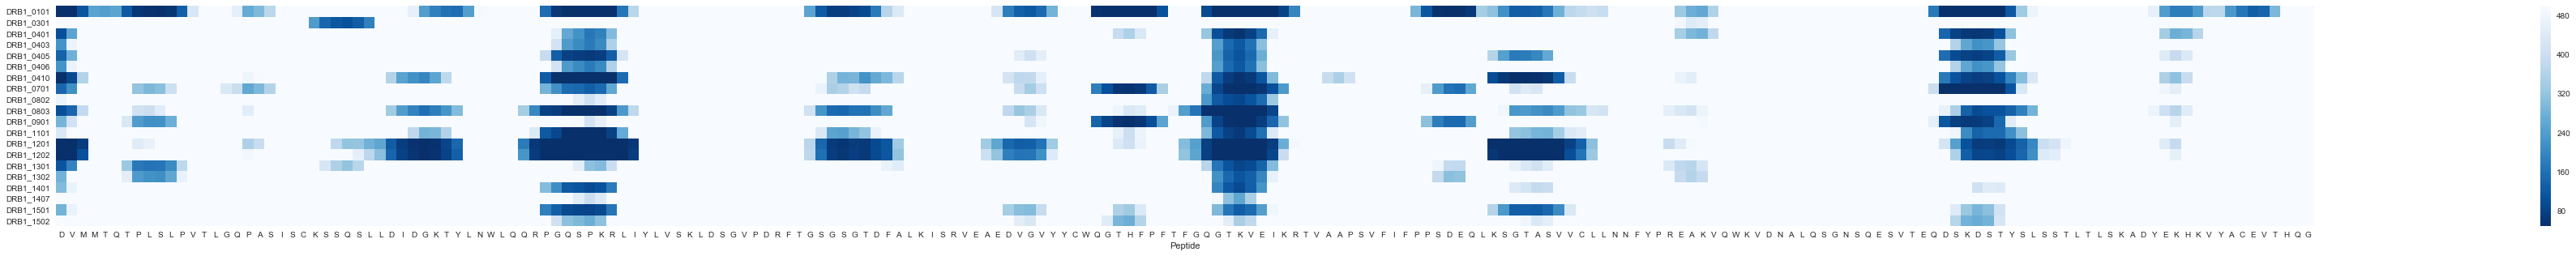

In [17]:
# 플롯 그리기
plt.figure(figsize=(100,5))
sns.heatmap(make_simple(df_MG1113LC).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
plt.savefig('df_M113LC.png',dpi=120,format='png',bbox_inches='tight')

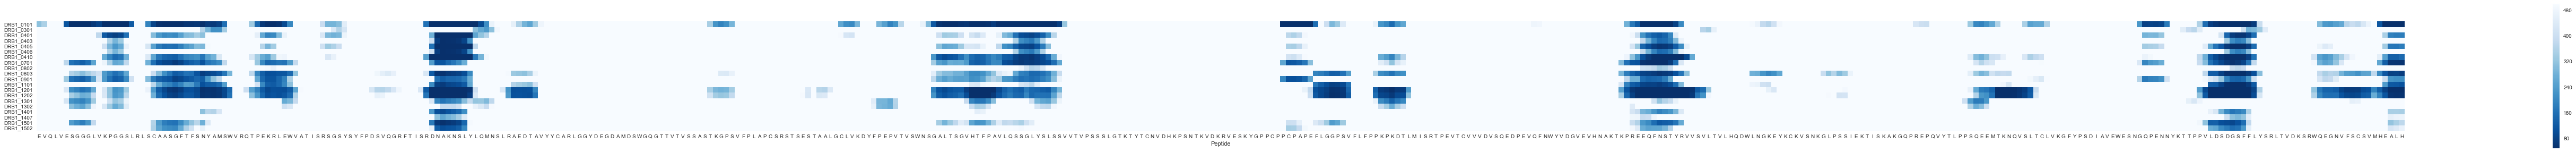

In [16]:
# 플롯 그리기
plt.figure(figsize=(100,5))
sns.heatmap(make_simple(df_mAb2021HC).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
plt.savefig('df_mAb2021HC.png',dpi=120,format='png',bbox_inches='tight')

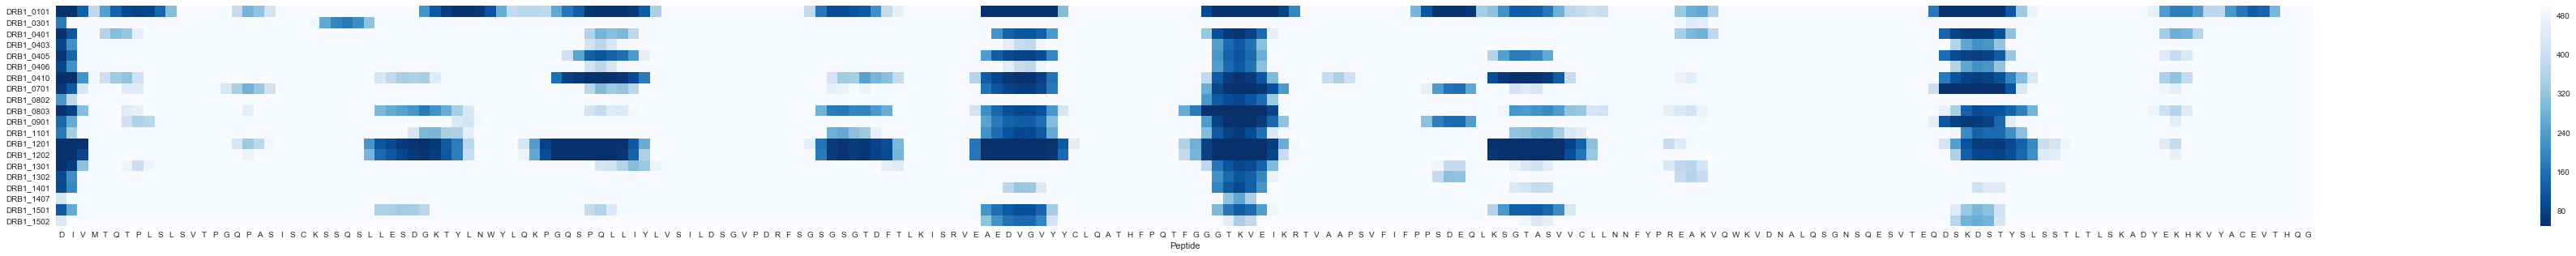

In [15]:
# 플롯 그리기
plt.figure(figsize=(100,5))
sns.heatmap(make_simple(df_mAb2021LC).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
plt.savefig('df_mAb2021LC.png',dpi=120,format='png',bbox_inches='tight')

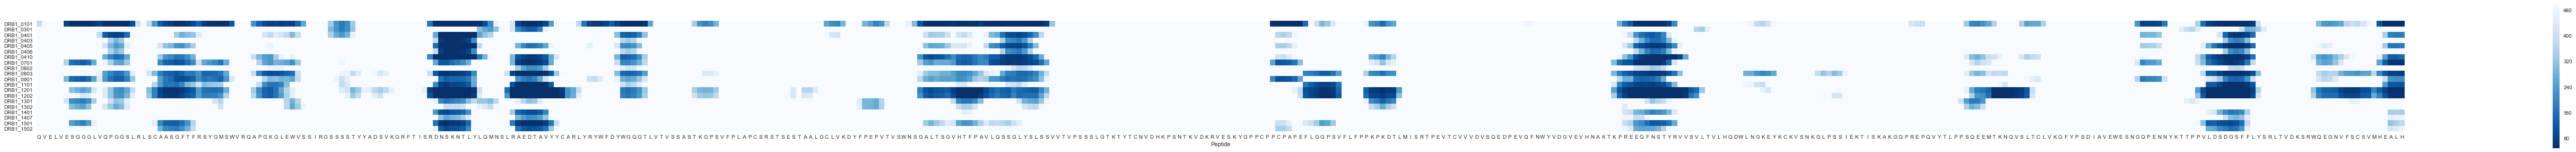

In [14]:
# 플롯 그리기
plt.figure(figsize=(100,5))
sns.heatmap(make_simple(df_Bay_HC).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
plt.savefig('df_Bay_HC.png',dpi=120,format='png',bbox_inches='tight')

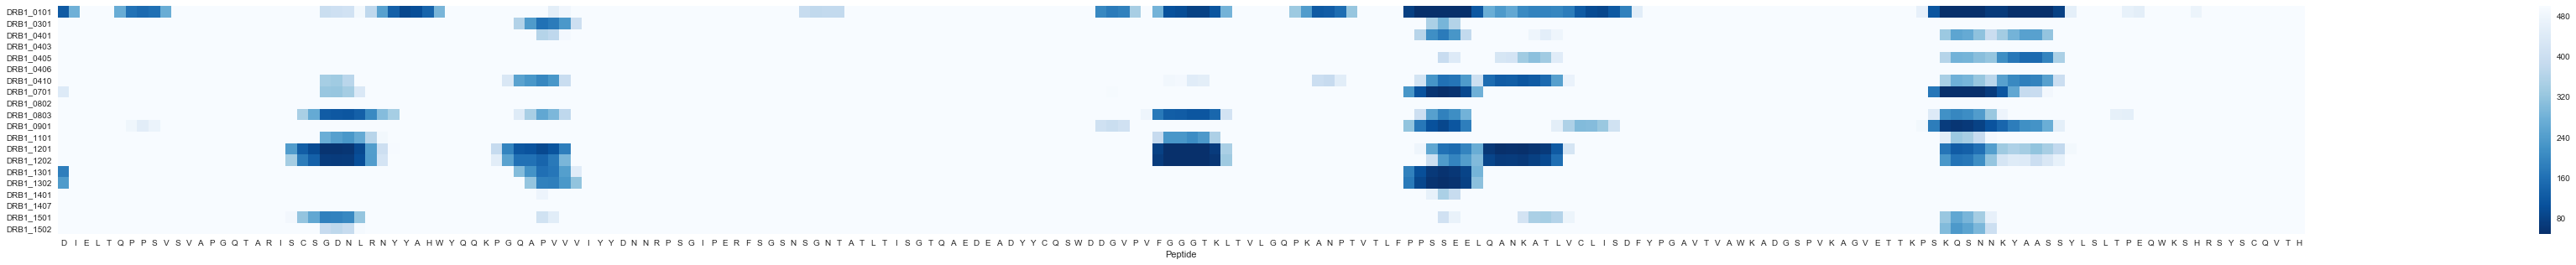

In [13]:
# 플롯 그리기
plt.figure(figsize=(100,5))
sns.heatmap(make_simple(df_Bay_LC).T,cmap='Blues_r',square=True, vmax = 500, vmin = 50)
plt.savefig('df_Bay_LC.png',dpi=120,format='png',bbox_inches='tight')

## 2. 마치며

총 6종류의 단백질에 대한 각각의 면역원성을 분석했습니다. allele에 따라 면역반응이 다르지만 전체적으로 파란색을 띄는 서열을 직관적으로 알 수 있습니다. 

만약 인위적으로 넣은 서열이 매우 푸른색을 띈다면 피하는 편이 좋습니다.